In [91]:
import numpy as np, pandas as pd
from ISLP import load_data
import seaborn as sns
from matplotlib import pyplot as plt
import ISLP
from ISLP import load_data
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError ,
    R2Score)
from sklearn.metrics import f1_score
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
import pytorch_lightning as L
from pytorch_lightning.loggers import CSVLogger
from torchvision.datasets import MNIST , CIFAR100
from IPython.display import clear_output
from torchvision.models import (resnet50 ,
    ResNet50_Weights)
from torchvision.transforms import (Resize ,
    Normalize ,
    CenterCrop ,
    ToTensor)
from ISLP.torch import (SimpleDataModule ,
    SimpleModule ,
    ErrorTracker ,
    rec_num_workers)
from ISLP.torch.imdb import (load_lookup ,
    load_tensor ,
    load_sparse ,
    load_sequential)
from glob import glob
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import json
sns.set_palette("pastel")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
def add_na(original, size):
    with_na = original.copy()
    n_lost = np.random.randint(original.shape[0], size=size)
    p_lost = np.random.randint(original.shape[1], size=size)
    losts = tuple((zip(n_lost, p_lost)))
    for lost in losts:
        with_na.iloc[lost[0], lost[1]] = np.nan
    return with_na, tuple(set(losts))

In [97]:
def impute(scaled_df, losts, n_components = None, n_iter = 50):
    loss_evol = []
    
    # Let's replace the NaN by the mean of the columns
    imputed = SimpleImputer().fit_transform(scaled_df)
    last_loss = float('inf')
    
    for iteration in range(n_iter):
        # Compute Loading verctors and scores
        pca = PCA(n_components = n_components).fit(imputed)
        Z = pca.transform(imputed)
        M = pca.components_
    
        # Impute the value using the Zscore and the loading vectors
        for i, j in losts:
            Zm = Z[i, :]
            Mj = M[:, j]
            imputed[i, j] = np.dot(Zm, Mj)
    
        # Compute the loss function
        loss = []
        for i, j in np.ndindex(imputed.shape):
            if (i, j) in losts:
                continue
            Zm = Z[i, :]
            Mj = M[:, j]
            loss.append(np.square(imputed[i, j] - np.dot(Zm, Mj)))
        loss = np.mean(loss)
        loss_evol.append(loss)
        if last_loss <= loss:
            # print(f"Iteration : {iteration} Loss didn't decrease :  {loss}")
            break
        else:
            last_loss = loss
            # print(f'Iteration : {iteration} Loss is : {loss}')
    return imputed, loss_evol

In [98]:
def evaluate_solution(original, imputed, lost):
    se = []
    for i, j in losts:
        se.append(np.square(original[i, j] - imputed[i, j]))
    return np.mean(se)

In [103]:
Boston = load_data('Boston')
missing, losts = add_na(Boston, 2000)
scaled = StandardScaler().fit_transform(missing)
original_scaled = StandardScaler().fit_transform(Boston)

In [104]:
mean_impute = SimpleImputer().fit_transform(scaled)
imputed, loss_evol = impute(scaled, losts, n_components=11)
mean_mse = evaluate_solution(original_scaled, imputed, losts)
imputed_mse = evaluate_solution(original_scaled, mean_impute, losts)
print(f'The PCA imputation mse is : {imputed_mse:2f}')
print(f'The mean imputation mse is : {mean_mse:2f}')
print(f'Diff is : {(imputed_mse - mean_mse):2f}')

The PCA imputation mse is : 0.954974
The mean imputation mse is : 0.981787
Diff is : -0.026814


<Axes: >

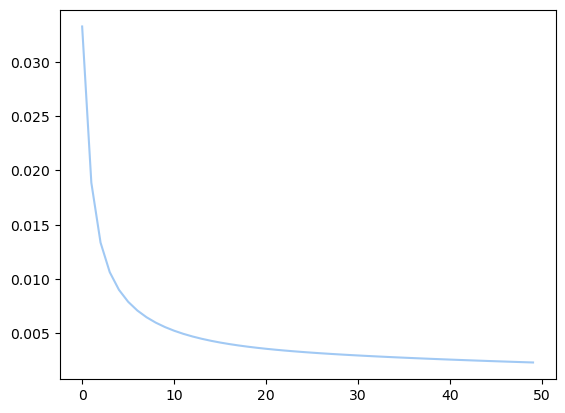

In [75]:
sns.lineplot(loss_evol)

In [148]:
nan_size_list = [ int((5/100) * Boston.size * i) for i in range(1,7)]
n_components_list = [ i for i in range(1,9) ]

In [ ]:
nan_size_mse = {}
for nan_size in nan_size_list:
    n_components_mse = []
    for n_components in n_components_list:
        mse = []
        for _ in range(10):
            missing, losts = add_na(Boston, nan_size)
            scaled = StandardScaler().fit_transform(missing)
            imputed, _ = impute(scaled, losts, n_components=n_components)
            mse.append(evaluate_solution(original_scaled, imputed, losts))
        n_components_mse.append(np.mean(mse))
        print(nan_size, n_components)
    nan_size_mse[f'{int(100 * nan_size/Boston.size)+1}_nan_percent'] = n_components_mse

In [ ]:
nan_size_mse

<Axes: >

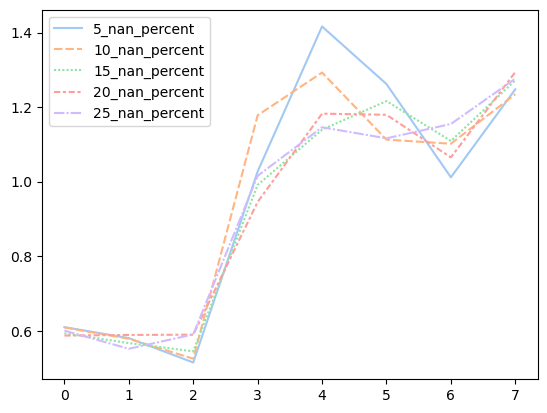

In [151]:
sns.lineplot(nan_size_mse)

In [160]:
mse = []
for nan_size in nan_size_list:
    missing, losts = add_na(Boston, nan_size)
    scaled = StandardScaler().fit_transform(missing)
    mean_impute = SimpleImputer().fit_transform(scaled)
    mse.append(evaluate_solution(original_scaled, mean_impute, losts))

<Axes: >

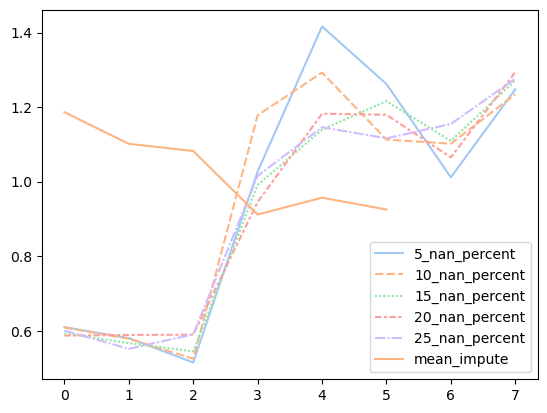

In [164]:
sns.lineplot(nan_size_mse)
sns.lineplot(mse, label='mean_impute')